In [28]:
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121
%pip install pytorch-lightning
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%pip install tensorboard
%pip install nibabel

Looking in indexes: https://download.pytorch.org/whl/cu121


In [29]:
# Import required modules
import os
import urllib.request
import pathlib

# Since we're in a notebook, we'll set the parent directory relative to current working directory
parent_dir = pathlib.Path(os.getcwd()).parent

# URLs for the tar files
t1_url = "http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar"
t2_url = "http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T2.tar"

# Download tar files if they don't exist
for url, filename in [(t1_url, "IXI-T1.tar"), (t2_url, "IXI-T2.tar")]:
    filepath = parent_dir / filename
    if not filepath.exists():
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filepath)
    else:
        print(f"{filename} already exists.")

# Create data directories if they don't exist
data_dir = parent_dir / "data"
t1_dir = data_dir / "IXI_T1"
t2_dir = data_dir / "IXI_T2"

t1_dir.mkdir(parents=True, exist_ok=True)
t2_dir.mkdir(parents=True, exist_ok=True)

# Extract T1 and T2 tar files into their respective directories
import subprocess
subprocess.run(['tar', '-xf', parent_dir / "IXI-T1.tar", '-C', t1_dir])
subprocess.run(['tar', '-xf', parent_dir / "IXI-T2.tar", '-C', t2_dir])

# Count number of T1 and T2 files
# Filter and count T1 NIfTI files in the T1 directory
t1_count = len(list(t1_dir.glob('*.nii.gz')))
# Filter and count T2 NIfTI files in the T2 directory
t2_count = len(list(t2_dir.glob('*.nii.gz')))

print(f"Data extracted successfully. Found {t1_count} T1 scans and {t2_count} T2 scans.")

Data extracted successfully. Found 581 T1 scans and 578 T2 scans.


In [ ]:
# Cell 1: All necessary imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchvision import transforms

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import random

## Dataset and Dataloader

In [ ]:
class MRIT1T2Dataset(Dataset):
    """Dataset class for loading paired/unpaired T1-T2 MRI data.
    Handles loading, validation, normalization and caching of MRI volumes."""

    def __init__(self, t1_dir, t2_dir, slice_mode='middle', paired=True, transform=None, cache_size=0):
        """
        Args:
            t1_dir (str): Directory containing T1 scans
            t2_dir (str): Directory containing T2 scans
            slice_mode (str): 'middle' or 'random' - how to select slice from volume
            paired (bool): If True, uses paired T1-T2 data, else random unpaired selection
            transform: Optional transforms to apply to slices
            cache_size (int): Number of volumes to cache in memory (0 for no caching)
        """
        super().__init__()

        # Add resize transform
        self.resize_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((128, 128)),
            transforms.ToTensor()
        ])

        # Store initialization parameters
        self.t1_dir = t1_dir
        self.t2_dir = t2_dir
        self.transform = transform
        self.slice_mode = slice_mode
        self.paired = paired
        self.cache_size = cache_size

        # Get lists of all NIfTI files (.nii.gz)
        self.t1_files = sorted([f for f in os.listdir(t1_dir) if f.endswith('.nii.gz')])
        self.t2_files = sorted([f for f in os.listdir(t2_dir) if f.endswith('.nii.gz')])

        # For paired training, find matching T1-T2 pairs based on subject ID
        if self.paired:
            self.paired_files = []
            for t1f in self.t1_files:
                subject_id = t1f.split('-')[0][3:]  # Extract subject ID from filename
                matching_t2 = [t2f for t2f in self.t2_files if t2f.split('-')[0][3:] == subject_id]
                if matching_t2:
                    self.paired_files.append((t1f, matching_t2[0]))
            print(f"Found {len(self.paired_files)} paired T1/T2 datasets")
            self.data_files = self.paired_files
        else:
            # For unpaired, just use T1 files and randomly select T2 later
            self.data_files = [(t1f, None) for t1f in self.t1_files]

        # Initialize cache dictionary
        self.cache = {}

    def _load_and_validate_volume(self, filename, is_t1=True):
        """Load and validate a single MRI volume.

        Args:
            filename (str): Name of the NIfTI file
            is_t1 (bool): Whether this is a T1 volume (determines directory)

        Returns:
            tuple: (volume data array, (min_value, max_value))
        """
        dir_path = self.t1_dir if is_t1 else self.t2_dir
        filepath = os.path.join(dir_path, filename)

        # Check if volume is in cache
        if filepath in self.cache:
            vol = self.cache[filepath]
        else:
            # Load volume using NiBabel
            vol = nib.load(filepath).get_fdata()

            # Validate volume
            if not self.is_valid_volume(vol):
                raise ValueError(f"Invalid volume: {filename}")

            # Cache volume if cache isn't full
            if len(self.cache) < self.cache_size:
                self.cache[filepath] = vol

        # Calculate volume statistics for normalization
        stats = (float(vol.min()), float(vol.max()))

        return vol, stats

    def is_valid_volume(self, vol):
        """Check if volume meets quality criteria.

        Args:
            vol (np.ndarray): Volume data

        Returns:
            bool: True if volume is valid
        """
        min_size = 64  # Minimum dimension size
        return (vol.shape[0] >= min_size and
                vol.shape[1] >= min_size and
                vol.shape[2] >= 1 and
                not np.any(np.isnan(vol)))

    def get_slice_idx(self, volume):
        """Get slice index based on slice_mode setting.

        Args:
            volume (np.ndarray): Volume data

        Returns:
            int: Index of slice to extract
        """
        if self.slice_mode == 'middle':
            return volume.shape[2] // 2
        else:  # random
            return random.randint(0, volume.shape[2] - 1)

    def __len__(self):
        """Return the total number of T1-T2 pairs in the dataset."""
        return len(self.data_files)

    def __getitem__(self, idx):
        """Get a T1-T2 pair of slices.

        Args:
            idx (int): Index of the pair

        Returns:
            dict: Contains 'T1' and 'T2' tensor slices
        """
        t1_file, t2_file = self.data_files[idx]

        # Load T1 volume and its statistics
        t1_vol, t1_stats = self._load_and_validate_volume(t1_file, is_t1=True)

        if self.paired:
            # Load matching T2 volume for paired data
            t2_vol, t2_stats = self._load_and_validate_volume(t2_file, is_t1=False)
        else:
            # For unpaired data, randomly select a T2 volume
            random_t2_idx = random.randint(0, len(self.t2_files) - 1)
            t2_vol, t2_stats = self._load_and_validate_volume(self.t2_files[random_t2_idx], is_t1=False)

        # Determine slice indices independently based on slice_mode
        if self.slice_mode == 'middle':
            t1_slice_idx = t1_vol.shape[2] // 2
            t2_slice_idx = t2_vol.shape[2] // 2
        else:  # 'random'
            t1_slice_idx = random.randint(0, t1_vol.shape[2] - 1)
            t2_slice_idx = random.randint(0, t2_vol.shape[2] - 1)

        # Extract and normalize the slices
        t1_slice = self.normalize_slice(t1_vol[:, :, t1_slice_idx], t1_stats)
        t2_slice = self.normalize_slice(t2_vol[:, :, t2_slice_idx], t2_stats)

        # Convert slices to tensors and add a channel dimension
        t1_tensor = torch.from_numpy(t1_slice).float().unsqueeze(0)
        t2_tensor = torch.from_numpy(t2_slice).float().unsqueeze(0)

        # Apply the resize transform (e.g., to 128x128)
        t1_tensor = self.resize_transform(t1_tensor)
        t2_tensor = self.resize_transform(t2_tensor)

        # Apply any additional transforms if provided
        if self.transform:
            t1_tensor = self.transform(t1_tensor)
            t2_tensor = self.transform(t2_tensor)

        # Clean up volumes if not cached
        if t1_file not in self.cache:
            del t1_vol
        if t2_file not in self.cache:
            del t2_vol

        return {'T1': t1_tensor, 'T2': t2_tensor}


    @staticmethod
    def normalize_slice(slice_data, stats):
        """Normalize slice to [0,1] range using pre-computed statistics.

        Args:
            slice_data (np.ndarray): Raw slice data
            stats (tuple): (min_value, max_value) for normalization

        Returns:
            np.ndarray: Normalized slice
        """
        min_val, max_val = stats
        return (slice_data - min_val) / (max_val - min_val + 1e-8)

## Model (U-net with Time + Cross-attention)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define an Identity module to bypass attention when not used.
class Identity(nn.Module):
    def forward(self, x, *args, **kwargs):
        return x

class TimeEmbedding(nn.Module):
    """Projects timesteps into a higher-dimensional space for time conditioning."""
    def __init__(self, n_channels):
        super().__init__()
        self.n_channels = n_channels
        self.time_proj = nn.Sequential(
            nn.Linear(1, n_channels),
            nn.SiLU(),
            nn.Linear(n_channels, n_channels)
        )
    def forward(self, t):
        # t: [B] -> [B, 1]
        t = t.unsqueeze(-1).float()
        return self.time_proj(t)  # [B, n_channels]

class ConvBlock(nn.Module):
    """A convolutional block with time conditioning and residual connections."""
    def __init__(self, in_channels, out_channels, time_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.time_mlp = nn.Linear(time_channels, out_channels)
        self.use_residual = in_channels == out_channels
        if not self.use_residual:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, 1)
    def forward(self, x, t):
        residual = x if self.use_residual else self.residual_conv(x)
        h = self.conv1(x)
        h = self.norm1(h)
        # Broadcast time embedding over spatial dimensions.
        h += self.time_mlp(t)[:, :, None, None]
        h = F.silu(h)
        h = self.conv2(h)
        h = self.norm2(h)
        h = F.silu(h)
        return h + residual

class SelfAttention(nn.Module):
    """Self-attention module to capture long-range dependencies."""
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, num_heads=4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )
    def forward(self, x):
        # x: [B, C, H, W] -> flatten spatial dims -> [B, HW, C]
        size = x.shape[-2:]
        x_flat = x.flatten(2).transpose(1, 2)
        x_norm = self.ln(x_flat)
        attn_out, _ = self.mha(x_norm, x_norm, x_norm)
        attn_out = attn_out + x_flat  # Skip connection
        ff_out = self.ff_self(attn_out) + attn_out
        # Restore spatial dims.
        return ff_out.transpose(1, 2).view(-1, self.channels, *size)

class CrossAttention(nn.Module):
    """Cross-attention module to attend between source and context features."""
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, num_heads=4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_cross = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )
    def forward(self, x, context):
        # x (query) and context (key/value) both: [B, C, H, W]
        size = x.shape[-2:]
        x_flat = x.flatten(2).transpose(1, 2)
        context_flat = context.flatten(2).transpose(1, 2)
        x_norm = self.ln(x_flat)
        attn_out, _ = self.mha(x_norm, context_flat, context_flat)
        attn_out = attn_out + x_flat  # Skip connection
        ff_out = self.ff_cross(attn_out) + attn_out
        return ff_out.transpose(1, 2).view(-1, self.channels, *size)

class UNet(nn.Module):
    """U-Net with optional self-attention and cross-attention for diffusion models."""
    def __init__(
        self,
        in_channels=3,
        time_channels=256,
        n_channels=64,
        use_self_attention=True,
        use_cross_attention=True
    ):
        """
        Args:
            in_channels (int): Number of input channels.
            time_channels (int): Dimension of time embedding.
            n_channels (int): Base number of channels.
            use_self_attention (bool): If True, apply self-attention.
            use_cross_attention (bool): If True, apply cross-attention in bottleneck.
        """
        super().__init__()

        self.use_cross_attention = use_cross_attention
        # Context projection (only matters if using cross-attention)
        self.context_proj = nn.Conv2d(1, n_channels * 8, kernel_size=1) if use_cross_attention else Identity()

        # Time embedding
        self.time_embed = TimeEmbedding(time_channels)

        # Encoder path
        self.inc = ConvBlock(in_channels, n_channels, time_channels)
        self.down1 = nn.ModuleList([
            nn.MaxPool2d(2),
            ConvBlock(n_channels, n_channels*2, time_channels),
            SelfAttention(n_channels*2) if use_self_attention else Identity()
        ])
        self.down2 = nn.ModuleList([
            nn.MaxPool2d(2),
            ConvBlock(n_channels*2, n_channels*4, time_channels),
            SelfAttention(n_channels*4) if use_self_attention else Identity()
        ])
        self.down3 = nn.ModuleList([
            nn.MaxPool2d(2),
            ConvBlock(n_channels*4, n_channels*8, time_channels),
            SelfAttention(n_channels*8) if use_self_attention else Identity()
        ])

        # Bottleneck with attention
        self.bot1 = ConvBlock(n_channels*8, n_channels*8, time_channels)
        self.bot_attn = SelfAttention(n_channels*8) if use_self_attention else Identity()
        self.cross_attn = CrossAttention(n_channels*8) if use_cross_attention else Identity()
        self.bot2 = ConvBlock(n_channels*8, n_channels*8, time_channels)
        self.bot3 = ConvBlock(n_channels*8, n_channels*8, time_channels)

        # Decoder path with skip connections
        self.up1 = nn.ModuleList([
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            ConvBlock(n_channels*12, n_channels*4, time_channels),  # Concatenation: x4 (n_channels*8) and x3 (n_channels*4)
            SelfAttention(n_channels*4) if use_self_attention else Identity()
        ])
        self.up2 = nn.ModuleList([
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            ConvBlock(n_channels*6, n_channels*2, time_channels),   # Concatenation: previous output (n_channels*4) with x2 (n_channels*2)
            SelfAttention(n_channels*2) if use_self_attention else Identity()
        ])
        self.up3 = nn.ModuleList([
            ConvBlock(n_channels*3, n_channels, time_channels)        # Concatenation: previous output (n_channels*2) with x1 (n_channels)
        ])

        # Output convolution
        self.outc = nn.Conv2d(n_channels, 1, 1)

    def forward(self, x, t, condition=None, context=None):
        """
        Args:
            x (torch.Tensor): Input tensor [B, C, H, W].
            t (torch.Tensor): Timesteps [B].
            condition (torch.Tensor, optional): Conditioning image.
            context (torch.Tensor, optional): Context image for cross-attention [B, 1, H, W].

        Returns:
            torch.Tensor: Output tensor [B, 1, H, W].
        """
        # Add conditioning channel if provided.
        if condition is not None:
            condition = condition.expand(-1, 1, x.shape[2], x.shape[3])
            x = torch.cat([x, condition], dim=1)

        # Time embedding
        t_emb = self.time_embed(t)

        # Encoder
        x1 = self.inc(x, t_emb)
        x2 = self.down1[0](x1)  # MaxPool2d
        x2 = self.down1[1](x2, t_emb)
        x2 = self.down1[2](x2)

        x3 = self.down2[0](x2)
        x3 = self.down2[1](x3, t_emb)
        x3 = self.down2[2](x3)

        x4 = self.down3[0](x3)
        x4 = self.down3[1](x4, t_emb)
        x4 = self.down3[2](x4)

        # Bottleneck
        x4 = self.bot1(x4, t_emb)
        x4 = self.bot_attn(x4)
        if context is not None:
            # Project context to match bottleneck dimensions
            context_proj = self.context_proj(context)
            x4 = self.cross_attn(x4, context_proj)
        x4 = self.bot2(x4, t_emb)
        x4 = self.bot3(x4, t_emb)

        # Decoder
        # Upsample x4 to match spatial dims of x3
        x4 = F.interpolate(x4, size=x3.shape[-2:], mode='bilinear', align_corners=True)
        x = torch.cat([x4, x3], dim=1)
        x = self.up1[0](x)
        x = self.up1[1](x, t_emb)
        x = self.up1[2](x)

        x = torch.cat([x, x2], dim=1)
        x = self.up2[0](x)
        x = self.up2[1](x, t_emb)
        x = self.up2[2](x)

        x = torch.cat([x, x1], dim=1)
        x = self.up3[0](x, t_emb)

        return self.outc(x)


## Diffusion Trainer Class

In [ ]:
class DDPMTrainer:
    """Denoising Diffusion Probabilistic Models (DDPM) Trainer.
    Handles the training process, including:
    - Forward/reverse diffusion processes
    - Optimization
    - Mixed precision training
    - Sampling
    """

    def __init__(
        self, model, n_timesteps=1000, beta_start=1e-4, beta_end=0.02,
        lr=1e-4, device="cuda"
    ):
        """
        Args:
            model: UNet model instance
            n_timesteps (int): Number of diffusion timesteps
            beta_start (float): Starting noise schedule value
            beta_end (float): Ending noise schedule value
            lr (float): Learning rate for Adam optimizer
            device (str): Device to run on ("cuda" or "cpu")
        """
        self.model = model.to(device)
        self.device = device
        self.n_timesteps = n_timesteps

        # Setup noise schedule
        self.betas = torch.linspace(beta_start, beta_end, n_timesteps).to(device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

        # Pre-compute values for diffusion process
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)

        # Setup optimizer
        self.optimizer = Adam(self.model.parameters(), lr=lr)

    def diffuse_step(self, x_0, t):
        """Forward diffusion step: adds noise to image according to timestep.

        Args:
            x_0 (torch.Tensor): Original clean image
            t (torch.Tensor): Timesteps for batch

        Returns:
            tuple: (noisy image, noise added)
        """
        noise = torch.randn_like(x_0)  # Random noise

        # Get noise scaling factors for timestep t
        sqrt_alpha_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)

        # Apply forward diffusion equation
        x_t = sqrt_alpha_t * x_0 + sqrt_one_minus_alpha_t * noise
        return x_t, noise

    def train_one_batch(self, x_0, condition=None, context=None):
        """Trains model on a single batch.

        Args:
            x_0 (torch.Tensor): Clean images [B, C, H, W]
            condition (torch.Tensor, optional): Conditioning information
            context (torch.Tensor, optional): Context for cross-attention

        Returns:
            float: Batch loss value
        """
        batch_size = x_0.shape[0]
        # Sample random timesteps for batch
        t = torch.randint(0, self.n_timesteps, (batch_size,), device=self.device)

        # Apply forward diffusion
        x_t, noise = self.diffuse_step(x_0, t)

        # Forward pass (removed autocast since it's not supported on MPS)
        noise_pred = self.model(x_t, t, condition=condition, context=context)
        # Calculate loss between predicted and actual noise
        loss = F.mse_loss(noise_pred, noise)

        # Optimizer step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    @torch.no_grad()
    def sample(self, condition=None, context=None, shape=None, n_steps=None):
        """Generates samples using the reverse diffusion process.

        Args:
            condition (torch.Tensor, optional): Conditioning information
            context (torch.Tensor, optional): Context for cross-attention
            shape (tuple): Shape of samples to generate
            n_steps (int, optional): Number of sampling steps

        Returns:
            torch.Tensor: Generated samples
        """
        if n_steps is None:
            n_steps = self.n_timesteps

        # Start from pure noise
        x_t = torch.randn(shape, device=self.device)

        # Gradually denoise the sample
        for t in reversed(range(n_steps)):
            t_batch = torch.ones(shape[0], device=self.device, dtype=torch.long) * t

            # Predict noise in current sample
            noise_pred = self.model(x_t, t_batch, condition=condition, context=context)

            # Get diffusion parameters for timestep t
            alpha_t = self.alphas[t]
            alpha_t_cumprod = self.alphas_cumprod[t]
            beta_t = self.betas[t]

            # Add noise only if not the final step
            if t > 0:
                noise = torch.randn_like(x_t)
            else:
                noise = 0.

            # Apply reverse diffusion equation
            x_t = (1 / torch.sqrt(alpha_t)) * (
                x_t - beta_t / torch.sqrt(1 - alpha_t_cumprod) * noise_pred
            ) + torch.sqrt(beta_t) * noise

        return x_t


class MetricsTracker:
    """Tracks and computes various metrics during training."""

    def __init__(self, device):
        """
        Args:
            device: Device to run metrics computation on
        """
        self.psnr = PeakSignalNoiseRatio().to(device)
        self.ssim = StructuralSimilarityIndexMeasure().to(device)
        self.reset()

    def reset(self):
        """Resets all metrics for new epoch."""
        self.train_losses = []
        self.psnr_scores = []
        self.ssim_scores = []

    def update(self, pred, target, loss=None):
        """Updates metrics with new batch results."""
        if loss is not None:
            self.train_losses.append(loss)
        if pred is not None and target is not None:
            self.psnr_scores.append(self.psnr(pred, target).item())
            self.ssim_scores.append(self.ssim(pred, target).item())

    def get_metrics(self):
        """Returns average metrics for the current period."""
        return {
            'loss': np.mean(self.train_losses) if self.train_losses else 0,
            'psnr': np.mean(self.psnr_scores) if self.psnr_scores else 0,
            'ssim': np.mean(self.ssim_scores) if self.ssim_scores else 0
        }

def visualize_samples(t1_real, t2_real, t1_gen, t2_gen, epoch, step, save=True):
    """Creates visualization grid of real and generated images.

    Args:
        t1_real, t2_real: Real T1 and T2 images
        t1_gen, t2_gen: Generated T1 and T2 images
        epoch (int): Current epoch
        step (int): Current step
        save (bool): Whether to save the plot
    """
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))

    # Real T1
    axes[0].imshow(t1_real[0,0].cpu().numpy().T, cmap='gray', origin='lower')
    axes[0].set_title('Real T1')
    axes[0].axis('off')

    # Real T2
    axes[1].imshow(t2_real[0,0].cpu().numpy().T, cmap='gray', origin='lower')
    axes[1].set_title('Real T2')
    axes[1].axis('off')

    # Generated T2 from T1
    axes[2].imshow(t2_gen[0,0].cpu().numpy().T, cmap='gray', origin='lower')
    axes[2].set_title('T1→T2')
    axes[2].axis('off')

    # Generated T1 from T2
    axes[3].imshow(t1_gen[0,0].cpu().numpy().T, cmap='gray', origin='lower')
    axes[3].set_title('T2→T1')
    axes[3].axis('off')

    plt.tight_layout()

    if save:
        plt.savefig(f'../visualizations/diffusion/samples_epoch{epoch}_step{step}.png')
        plt.close()
    else:
        plt.show()

## Training Loop Script

In [ ]:
from huggingface_hub import notebook_login

# This will prompt you for your Hugging Face token
notebook_login()

In [37]:
from huggingface_hub import Repository

In [ ]:
class Config:
    """Configuration class containing all training parameters and paths."""
    def __init__(self):
        # Data paths
        self.t1_dir = "/data/IXI_T1" #C:\Users\prart\CSYE7105\Diffusion\IXI-T1 # Go up one level from notebooks to root
        self.t2_dir = "/data/IXI_T2"

        # Model parameters
        self.in_channels = 2  # Image + condition channel
        self.time_channels = 256
        self.n_channels = 64
        self.n_timesteps = 1000 # Number of diffusion steps
        self.beta_start = 1e-4
        self.beta_end = 0.02

        # Training parameters
        self.batch_size = 1

        self.num_epochs = 200
        self.lr = 1e-4
        self.save_interval = 1000  # Save checkpoints every N steps

        # Directories setup - go up one level from notebooks to root
        self.checkpoint_dir = Path("./checkpoints/diffusion_base")
        self.vis_dir = Path("./visualizations/diffusion_base")
        self.log_dir = Path("./logs/diffusion_base")

        # Create directories if they don't exist
        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)
        self.vis_dir.mkdir(parents=True, exist_ok=True)
        self.log_dir.mkdir(parents=True, exist_ok=True)

        # Device
        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Initialize configuration
config = Config()

# Cell 8: Training Functions

def load_checkpoint(trainer, checkpoint_path):
    """Loads model and optimizer state from checkpoint.

    Args:
        trainer: DDPMTrainer instance
        checkpoint_path: Path to checkpoint file

    Returns:
        tuple: (epoch, global_step)
    """
    checkpoint = torch.load(checkpoint_path)
    trainer.model.load_state_dict(checkpoint['model_state_dict'])
    trainer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['global_step']


from huggingface_hub import HfApi

def save_checkpoint(trainer, epoch, global_step):
    """Saves model and optimizer state to checkpoint and uploads to Hugging Face Hub."""
    import torch
    import os

    # Define the checkpoint filename and path
    checkpoint_filename = f'model_epoch{epoch}_step{global_step}.pt'
    checkpoint_path = config.checkpoint_dir / checkpoint_filename

    # Save the checkpoint locally
    checkpoint = {
        'model_state_dict': trainer.model.state_dict(),
        'optimizer_state_dict': trainer.optimizer.state_dict(),
        'epoch': epoch,
        'global_step': global_step,
    }
    torch.save(checkpoint, checkpoint_path)
    HF_TOKEN = os.getenv("HF_TOKEN")
    # Upload the checkpoint to Hugging Face Hub
    api = HfApi(token=HF_TOKEN)
    api.upload_file(
        path_or_fileobj=str(checkpoint_path),
        path_in_repo=checkpoint_filename,
        repo_id="pk1801/Mri-Diffusion",
        repo_type="model",
    )


# Main Training Loop

def train_diffusion():
    """Main training function that handles the complete training pipeline."""

    # Initialize tensorboard writer
    writer = SummaryWriter(config.log_dir)

    # Initialize dataset and dataloader
    dataset = MRIT1T2Dataset(
        t1_dir=config.t1_dir,
        t2_dir=config.t2_dir,
        slice_mode='middle',
        paired=True
    )

    dataloader = DataLoader(
        dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=False
    )

    # Initialize model and trainer
    model = UNet(
        in_channels=config.in_channels,
        time_channels=config.time_channels,
        n_channels=config.n_channels,
        use_self_attention=True,
        use_cross_attention=True,
    )

    trainer = DDPMTrainer(
        model=model,
        n_timesteps=config.n_timesteps,
        beta_start=config.beta_start,
        beta_end=config.beta_end,
        lr=config.lr,
        device=config.device
    )

    # Initialize metrics tracker
    metrics = MetricsTracker(config.device)

    # Check for existing checkpoint
    start_epoch = 0
    global_step = 0
    if config.checkpoint_dir.exists():
        checkpoints = list(config.checkpoint_dir.glob('model_epoch*_step*.pt'))
        if checkpoints:
            latest_checkpoint = max(checkpoints, key=os.path.getctime)
            # Load checkpoint with weights_only=True to avoid security warning
            start_epoch, global_step = load_checkpoint(trainer, latest_checkpoint)
            print(f"Resuming from epoch {start_epoch}, step {global_step}")

    # Training loop
    for epoch in range(start_epoch, config.num_epochs):
        metrics.reset()
        epoch_pbar = tqdm(dataloader, desc=f"Epoch {epoch}")

        for batch_idx, batch in enumerate(epoch_pbar):
            # Move data to device
            t1 = batch['T1'].to(config.device)
            t2 = batch['T2'].to(config.device)

            # Train T1 -> T2
            loss_t1_t2 = trainer.train_one_batch(
                x_0=t2,            # Target is T2
                condition=t1,      # Condition on T1
                context=t1         # Cross-attention sees T1
            )

            # Train T2 -> T1
            loss_t2_t1 = trainer.train_one_batch(
                x_0=t1,            # Target is T1
                condition=t2,      # Condition on T2
                context=t2         # Cross-attention sees T2
            )

            # Update metrics
            avg_loss = (loss_t1_t2 + loss_t2_t1) / 2
            metrics.update(None, None, avg_loss)

            # Update progress bar
            epoch_pbar.set_postfix({
                'loss': f"{avg_loss:.4f}",
                'step': global_step
            })

            # Checkpoint and visualization
            if global_step % config.save_interval == 0:
                trainer.model.eval()
                with torch.no_grad():
                    # Generate samples
                    t2_gen = trainer.sample(
                        condition=t1,
                        context=t1,
                        shape=t1.shape
                    )
                    t1_gen = trainer.sample(
                        condition=t2,
                        context=t2,
                        shape=t2.shape
                    )

                    # Calculate metrics for generated images
                    metrics.update(t2_gen, t2)
                    metrics.update(t1_gen, t1)

                    # Visualize samples
                    # visualize_samples(
                    #     t1, t2,
                    #     t1_gen, t2_gen,
                    #     epoch, global_step
                    # )

                    # Log to tensorboard
                    current_metrics = metrics.get_metrics()
                    writer.add_scalar('Loss/train', current_metrics['loss'], global_step)
                    writer.add_scalar('Metrics/PSNR', current_metrics['psnr'], global_step)
                    writer.add_scalar('Metrics/SSIM', current_metrics['ssim'], global_step)
                    writer.add_images('Samples/T1', t1, global_step)
                    writer.add_images('Samples/T2', t2, global_step)
                    writer.add_images('Samples/T1_generated', t1_gen, global_step)
                    writer.add_images('Samples/T2_generated', t2_gen, global_step)

                    # Save checkpoint
                    save_checkpoint(trainer, epoch, global_step)

                trainer.model.train()

            global_step += 1

        # End of epoch
        epoch_metrics = metrics.get_metrics()
        print(f"\nEpoch {epoch} Summary:")
        print(f"Average Loss: {epoch_metrics['loss']:.4f}")
        print(f"Average PSNR: {epoch_metrics['psnr']:.2f}")
        print(f"Average SSIM: {epoch_metrics['ssim']:.4f}")

    writer.close()


if __name__ == "__main__":
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    # Start training
    train_diffusion()

Found 577 paired T1/T2 datasets


<ipython-input-39-96a3a50fc849>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resuming from epoch 95, step 57000


Epoch 95:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch95_step57000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 95 Summary:
Average Loss: 0.0081
Average PSNR: 15.48
Average SSIM: 0.1845


Epoch 96:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch96_step58000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 96 Summary:
Average Loss: 0.0087
Average PSNR: 14.83
Average SSIM: 0.2340


Epoch 97:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 97 Summary:
Average Loss: 0.0078
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 98:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch98_step59000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 98 Summary:
Average Loss: 0.0065
Average PSNR: 15.95
Average SSIM: 0.0994


Epoch 99:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 99 Summary:
Average Loss: 0.0076
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 100:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch100_step60000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 100 Summary:
Average Loss: 0.0081
Average PSNR: 14.71
Average SSIM: 0.0226


Epoch 101:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch101_step61000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 101 Summary:
Average Loss: 0.0088
Average PSNR: 16.76
Average SSIM: 0.2439


Epoch 102:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 102 Summary:
Average Loss: 0.0093
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 103:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch103_step62000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 103 Summary:
Average Loss: 0.0074
Average PSNR: 16.76
Average SSIM: 0.1448


Epoch 104:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 104 Summary:
Average Loss: 0.0081
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 105:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch105_step63000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 105 Summary:
Average Loss: 0.0085
Average PSNR: 14.21
Average SSIM: 0.1644


Epoch 106:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 106 Summary:
Average Loss: 0.0073
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 107:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch107_step64000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 107 Summary:
Average Loss: 0.0106
Average PSNR: 15.21
Average SSIM: 0.2565


Epoch 108:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch108_step65000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 108 Summary:
Average Loss: 0.0087
Average PSNR: 15.14
Average SSIM: 0.2534


Epoch 109:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 109 Summary:
Average Loss: 0.0079
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 110:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch110_step66000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 110 Summary:
Average Loss: 0.0072
Average PSNR: 16.07
Average SSIM: 0.2649


Epoch 111:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 111 Summary:
Average Loss: 0.0100
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 112:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch112_step67000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 112 Summary:
Average Loss: 0.0087
Average PSNR: 15.32
Average SSIM: 0.1243


Epoch 113:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 113 Summary:
Average Loss: 0.0084
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 114:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch114_step68000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 114 Summary:
Average Loss: 0.0076
Average PSNR: 14.93
Average SSIM: 0.1694


Epoch 115:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch115_step69000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 115 Summary:
Average Loss: 0.0080
Average PSNR: 13.87
Average SSIM: 0.2751


Epoch 116:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 116 Summary:
Average Loss: 0.0081
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 117:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch117_step70000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 117 Summary:
Average Loss: 0.0090
Average PSNR: 15.71
Average SSIM: 0.1232


Epoch 118:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 118 Summary:
Average Loss: 0.0066
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 119:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch119_step71000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 119 Summary:
Average Loss: 0.0088
Average PSNR: 16.03
Average SSIM: 0.3104


Epoch 120:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch120_step72000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 120 Summary:
Average Loss: 0.0090
Average PSNR: 16.78
Average SSIM: 0.2317


Epoch 121:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 121 Summary:
Average Loss: 0.0075
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 122:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch122_step73000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 122 Summary:
Average Loss: 0.0088
Average PSNR: 16.78
Average SSIM: 0.1947


Epoch 123:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 123 Summary:
Average Loss: 0.0081
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 124:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch124_step74000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 124 Summary:
Average Loss: 0.0083
Average PSNR: 16.24
Average SSIM: 0.2016


Epoch 125:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 125 Summary:
Average Loss: 0.0100
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 126:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch126_step75000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 126 Summary:
Average Loss: 0.0086
Average PSNR: 14.54
Average SSIM: 0.1977


Epoch 127:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch127_step76000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 127 Summary:
Average Loss: 0.0091
Average PSNR: 16.28
Average SSIM: 0.1733


Epoch 128:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 128 Summary:
Average Loss: 0.0092
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 129:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch129_step77000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 129 Summary:
Average Loss: 0.0080
Average PSNR: 15.31
Average SSIM: 0.2890


Epoch 130:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 130 Summary:
Average Loss: 0.0092
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 131:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch131_step78000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 131 Summary:
Average Loss: 0.0090
Average PSNR: 16.89
Average SSIM: 0.2988


Epoch 132:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 132 Summary:
Average Loss: 0.0093
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 133:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch133_step79000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 133 Summary:
Average Loss: 0.0063
Average PSNR: 16.37
Average SSIM: 0.2171


Epoch 134:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch134_step80000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 134 Summary:
Average Loss: 0.0079
Average PSNR: 15.94
Average SSIM: 0.1901


Epoch 135:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 135 Summary:
Average Loss: 0.0086
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 136:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch136_step81000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 136 Summary:
Average Loss: 0.0085
Average PSNR: 15.54
Average SSIM: 0.3382


Epoch 137:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 137 Summary:
Average Loss: 0.0077
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 138:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch138_step82000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 138 Summary:
Average Loss: 0.0082
Average PSNR: 19.15
Average SSIM: 0.3429


Epoch 139:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 139 Summary:
Average Loss: 0.0087
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 140:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch140_step83000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 140 Summary:
Average Loss: 0.0075
Average PSNR: 16.62
Average SSIM: 0.2858


Epoch 141:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch141_step84000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 141 Summary:
Average Loss: 0.0078
Average PSNR: 15.73
Average SSIM: 0.2753


Epoch 142:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 142 Summary:
Average Loss: 0.0087
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 143:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch143_step85000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 143 Summary:
Average Loss: 0.0076
Average PSNR: 13.82
Average SSIM: 0.2033


Epoch 144:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 144 Summary:
Average Loss: 0.0080
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 145:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch145_step86000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 145 Summary:
Average Loss: 0.0075
Average PSNR: 16.88
Average SSIM: 0.3085


Epoch 146:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch146_step87000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 146 Summary:
Average Loss: 0.0075
Average PSNR: 16.49
Average SSIM: 0.3026


Epoch 147:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 147 Summary:
Average Loss: 0.0075
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 148:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch148_step88000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 148 Summary:
Average Loss: 0.0087
Average PSNR: 14.23
Average SSIM: 0.3271


Epoch 149:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 149 Summary:
Average Loss: 0.0087
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 150:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch150_step89000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 150 Summary:
Average Loss: 0.0081
Average PSNR: 14.13
Average SSIM: 0.3366


Epoch 151:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 151 Summary:
Average Loss: 0.0086
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 152:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch152_step90000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 152 Summary:
Average Loss: 0.0097
Average PSNR: 16.22
Average SSIM: 0.3921


Epoch 153:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch153_step91000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 153 Summary:
Average Loss: 0.0069
Average PSNR: 15.95
Average SSIM: 0.1917


Epoch 154:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 154 Summary:
Average Loss: 0.0076
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 155:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch155_step92000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 155 Summary:
Average Loss: 0.0071
Average PSNR: 16.26
Average SSIM: 0.2666


Epoch 156:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 156 Summary:
Average Loss: 0.0080
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 157:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch157_step93000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 157 Summary:
Average Loss: 0.0078
Average PSNR: 14.57
Average SSIM: 0.3782


Epoch 158:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 158 Summary:
Average Loss: 0.0083
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 159:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch159_step94000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 159 Summary:
Average Loss: 0.0081
Average PSNR: 15.20
Average SSIM: 0.1568


Epoch 160:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch160_step95000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 160 Summary:
Average Loss: 0.0071
Average PSNR: 15.14
Average SSIM: 0.3716


Epoch 161:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 161 Summary:
Average Loss: 0.0069
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 162:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch162_step96000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 162 Summary:
Average Loss: 0.0075
Average PSNR: 15.64
Average SSIM: 0.3010


Epoch 163:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 163 Summary:
Average Loss: 0.0068
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 164:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch164_step97000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 164 Summary:
Average Loss: 0.0081
Average PSNR: 13.82
Average SSIM: 0.3665


Epoch 165:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 165 Summary:
Average Loss: 0.0077
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 166:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch166_step98000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 166 Summary:
Average Loss: 0.0068
Average PSNR: 15.92
Average SSIM: 0.2331


Epoch 167:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch167_step99000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 167 Summary:
Average Loss: 0.0074
Average PSNR: 15.32
Average SSIM: 0.2432


Epoch 168:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 168 Summary:
Average Loss: 0.0074
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 169:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch169_step100000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 169 Summary:
Average Loss: 0.0082
Average PSNR: 15.70
Average SSIM: 0.3835


Epoch 170:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 170 Summary:
Average Loss: 0.0068
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 171:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch171_step101000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 171 Summary:
Average Loss: 0.0076
Average PSNR: 14.58
Average SSIM: 0.1894


Epoch 172:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch172_step102000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 172 Summary:
Average Loss: 0.0083
Average PSNR: 16.31
Average SSIM: 0.4224


Epoch 173:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 173 Summary:
Average Loss: 0.0073
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 174:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch174_step103000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 174 Summary:
Average Loss: 0.0074
Average PSNR: 15.34
Average SSIM: 0.3399


Epoch 175:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 175 Summary:
Average Loss: 0.0059
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 176:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch176_step104000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 176 Summary:
Average Loss: 0.0092
Average PSNR: 15.85
Average SSIM: 0.3561


Epoch 177:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 177 Summary:
Average Loss: 0.0066
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 178:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch178_step105000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 178 Summary:
Average Loss: 0.0077
Average PSNR: 16.30
Average SSIM: 0.1118


Epoch 179:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch179_step106000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 179 Summary:
Average Loss: 0.0072
Average PSNR: 18.00
Average SSIM: 0.3187


Epoch 180:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 180 Summary:
Average Loss: 0.0092
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 181:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch181_step107000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 181 Summary:
Average Loss: 0.0088
Average PSNR: 16.81
Average SSIM: 0.4101


Epoch 182:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 182 Summary:
Average Loss: 0.0086
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 183:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch183_step108000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 183 Summary:
Average Loss: 0.0081
Average PSNR: 14.37
Average SSIM: 0.1666


Epoch 184:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 184 Summary:
Average Loss: 0.0066
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 185:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch185_step109000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 185 Summary:
Average Loss: 0.0079
Average PSNR: 13.06
Average SSIM: 0.3678


Epoch 186:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch186_step110000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 186 Summary:
Average Loss: 0.0079
Average PSNR: 16.53
Average SSIM: 0.3268


Epoch 187:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 187 Summary:
Average Loss: 0.0065
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 188:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch188_step111000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 188 Summary:
Average Loss: 0.0084
Average PSNR: 17.78
Average SSIM: 0.2095


Epoch 189:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 189 Summary:
Average Loss: 0.0080
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 190:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch190_step112000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 190 Summary:
Average Loss: 0.0070
Average PSNR: 12.69
Average SSIM: 0.3051


Epoch 191:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 191 Summary:
Average Loss: 0.0077
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 192:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch192_step113000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 192 Summary:
Average Loss: 0.0077
Average PSNR: 16.42
Average SSIM: 0.1841


Epoch 193:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch193_step114000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 193 Summary:
Average Loss: 0.0080
Average PSNR: 16.12
Average SSIM: 0.3631


Epoch 194:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 194 Summary:
Average Loss: 0.0075
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 195:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch195_step115000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 195 Summary:
Average Loss: 0.0078
Average PSNR: 16.76
Average SSIM: 0.3365


Epoch 196:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 196 Summary:
Average Loss: 0.0083
Average PSNR: 0.00
Average SSIM: 0.0000


Epoch 197:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch197_step116000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 197 Summary:
Average Loss: 0.0082
Average PSNR: 14.63
Average SSIM: 0.3446


Epoch 198:   0%|          | 0/577 [00:00<?, ?it/s]

model_epoch198_step117000.pt:   0%|          | 0.00/347M [00:00<?, ?B/s]


Epoch 198 Summary:
Average Loss: 0.0079
Average PSNR: 18.36
Average SSIM: 0.3715


Epoch 199:   0%|          | 0/577 [00:00<?, ?it/s]


Epoch 199 Summary:
Average Loss: 0.0086
Average PSNR: 0.00
Average SSIM: 0.0000


In [ ]:
# %pip install ipywidgets

In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)


In [41]:
model = UNet(
        in_channels=config.in_channels,   # should be 2 for [noisy T2, condition T1]
        time_channels=config.time_channels,
        n_channels=config.n_channels,
        use_self_attention=True,
        use_cross_attention=True,
    )

trainer = DDPMTrainer(
    model=model,
    n_timesteps=config.n_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    lr=config.lr,
    device=config.device
)
latest_checkpoint = "/content/checkpoints/diffusion_base/model_epoch198_step117000.pt"
load_checkpoint(trainer, latest_checkpoint)

<ipython-input-39-96a3a50fc849>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


(198, 117000)

Found 577 paired T1/T2 datasets
Sample 1: PSNR = 17.26, SSIM = 0.5632
Sample 2: PSNR = 19.13, SSIM = 0.3282
Sample 3: PSNR = 18.68, SSIM = 0.4997
Sample 4: PSNR = 16.13, SSIM = 0.4959
Sample 5: PSNR = 18.66, SSIM = 0.4786

Average PSNR: 17.97
Average SSIM: 0.4731


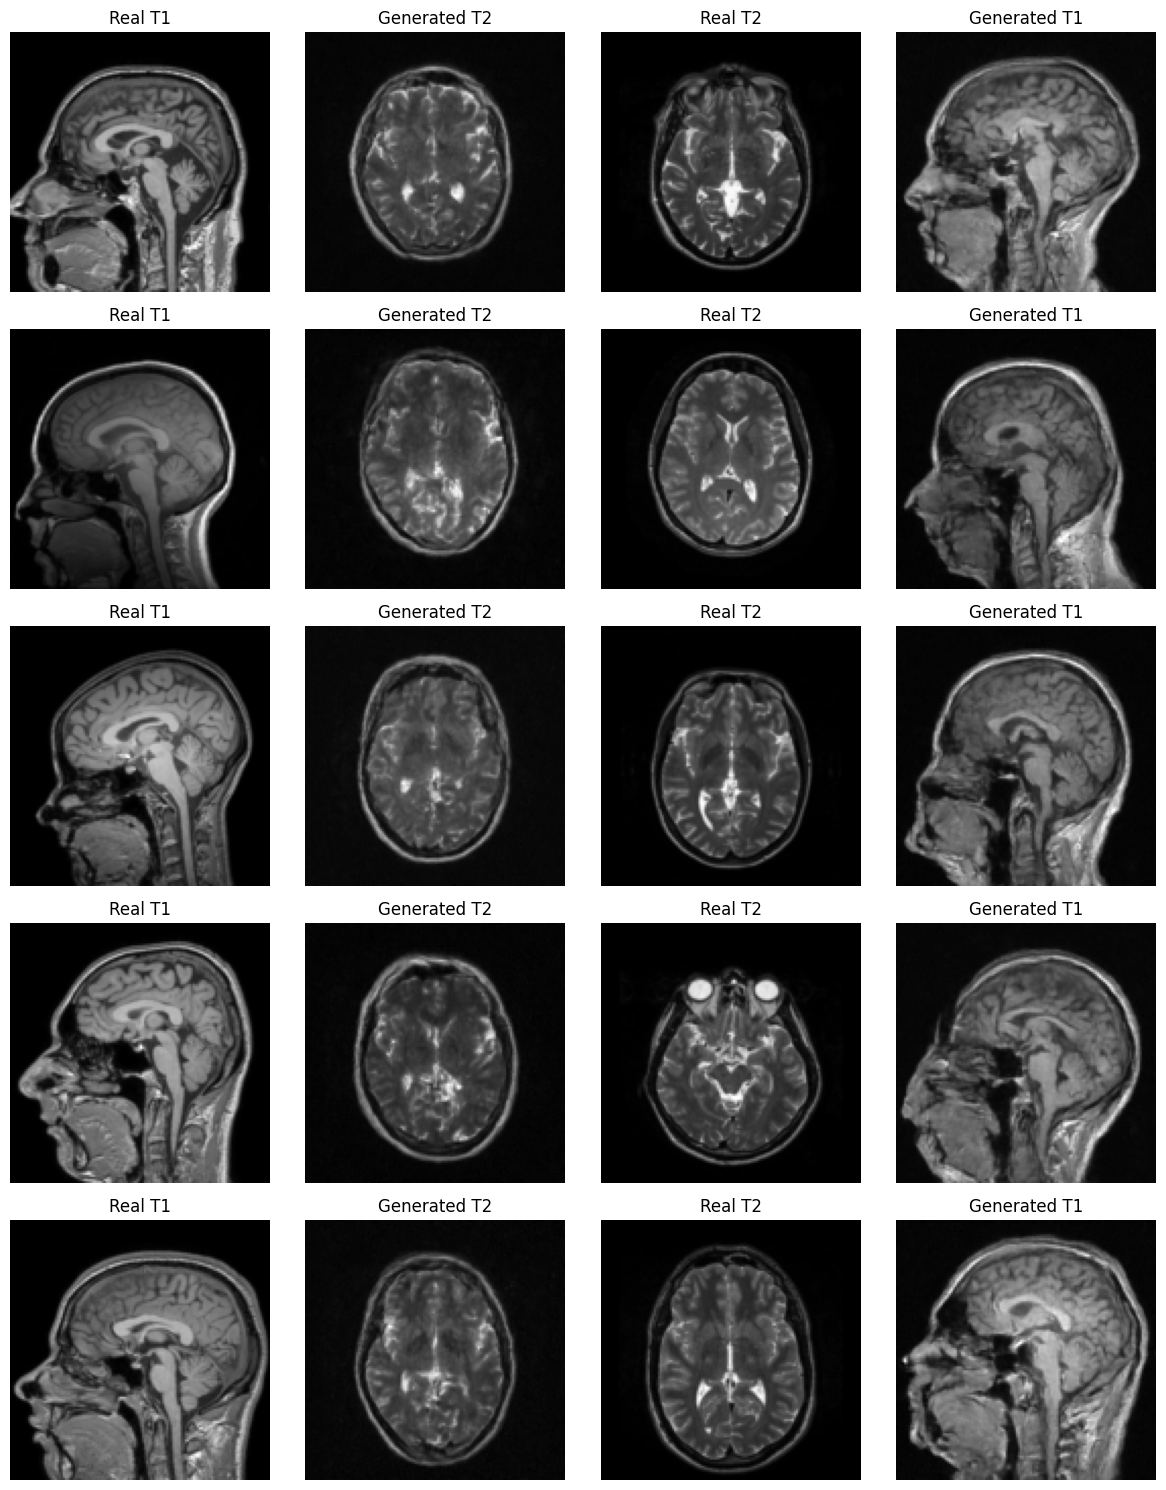

In [42]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

def evaluate_model(
    trainer, dataset, num_samples=5, save_path="evaluation_results.png"
):
    """Evaluate model on a few samples and visualize results."""
    device = config.device
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    psnr_metric = PeakSignalNoiseRatio().to(device)
    ssim_metric = StructuralSimilarityIndexMeasure().to(device)

    results = []
    psnr_total, ssim_total = 0.0, 0.0

    for i, batch in enumerate(dataloader):
        if i >= num_samples:
            break

        t1 = batch["T1"].to(device)
        t2 = batch["T2"].to(device)

        with torch.no_grad():
            t2_gen = trainer.sample(condition=t1, context=t1, shape=t1.shape)
            # Optional reverse direction
            t1_gen = trainer.sample(condition=t2, context=t2, shape=t2.shape)

        psnr = psnr_metric(t2_gen, t2).item()
        ssim = ssim_metric(t2_gen, t2).item()
        psnr_total += psnr
        ssim_total += ssim

        print(f"Sample {i+1}: PSNR = {psnr:.2f}, SSIM = {ssim:.4f}")

        results.append({
            "t1": t1[0, 0].cpu().numpy(),
            "t2": t2[0, 0].cpu().numpy(),
            "t2_gen": t2_gen[0, 0].cpu().numpy(),
            "t1_gen": t1_gen[0, 0].cpu().numpy(),
        })

    avg_psnr = psnr_total / num_samples
    avg_ssim = ssim_total / num_samples
    print(f"\nAverage PSNR: {avg_psnr:.2f}")
    print(f"Average SSIM: {avg_ssim:.4f}")

    # Plot side-by-side results
    fig, axs = plt.subplots(num_samples, 4, figsize=(12, 3 * num_samples))
    for i, sample in enumerate(results):
        axs[i, 0].imshow(sample["t1"].T, cmap="gray", origin="lower")
        axs[i, 0].set_title("Real T1")
        axs[i, 1].imshow(sample["t2_gen"].T, cmap="gray", origin="lower")
        axs[i, 1].set_title("Generated T2")
        axs[i, 2].imshow(sample["t2"].T, cmap="gray", origin="lower")
        axs[i, 2].set_title("Real T2")
        axs[i, 3].imshow(sample["t1_gen"].T, cmap="gray", origin="lower")
        axs[i, 3].set_title("Generated T1")
        for ax in axs[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

eval_dataset = MRIT1T2Dataset(
    t1_dir=config.t1_dir,
    t2_dir=config.t2_dir,
    slice_mode='middle',
    paired=True
)



# Assuming trainer and dataset already exist
evaluate_model(trainer, eval_dataset, num_samples=5)

In [47]:
# Reduce the number of workers and add error handling
batch_size = 1
eval_loader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues for now
    pin_memory=True
)

# Try to get a batch with error handling
try:
    # Get a batch of data for evaluation
    for eval_batch in eval_loader:
        t1_images = eval_batch['T1'].to(trainer.device)
        t2_images = eval_batch['T2'].to(trainer.device)  # Ground truth T2 images
        break  # Just get the first batch
except Exception as e:
    print(f"Error loading data: {e}")
    # Fallback: Try loading a single sample if batch loading fails
    single_sample = eval_dataset[0]
    t1_images = single_sample['T1'].unsqueeze(0).to(trainer.device)  # Add batch dimension
    t2_images = single_sample['T2'].unsqueeze(0).to(trainer.device)  # Add batch dimension
    batch_size = 1
    print(f"Falling back to single sample with shape: {t1_images.shape}")

# Define the diffusion steps to evaluate
step_counts = [10, 100, 300,500, 1000]  # Add full steps for comparison
samples_at_steps = {}

# Generate samples at different step counts
for steps in step_counts:
    print(f"Generating samples with {steps} reverse diffusion steps...")

    # Sample from the model
    samples = trainer.sample(
        condition=t1_images,
        shape=t1_images.shape,  # Use same shape as input
        n_steps=steps
    )

    samples_at_steps[steps] = samples

    # Calculate metrics between generated T2 and ground truth T2
    metrics = MetricsTracker(trainer.device)
    metrics.update(samples, t2_images)
    current_metrics = metrics.get_metrics()

    print(f"Metrics at {steps} steps:")
    print(f"PSNR: {current_metrics['psnr']:.4f}")
    print(f"SSIM: {current_metrics['ssim']:.4f}")

Generating samples with 10 reverse diffusion steps...
Metrics at 10 steps:
PSNR: -1.0297
SSIM: 0.0139
Generating samples with 100 reverse diffusion steps...
Metrics at 100 steps:
PSNR: 12.0963
SSIM: 0.0301
Generating samples with 300 reverse diffusion steps...
Metrics at 300 steps:
PSNR: 18.0266
SSIM: 0.2217
Generating samples with 500 reverse diffusion steps...
Metrics at 500 steps:
PSNR: 18.6120
SSIM: 0.4337
Generating samples with 1000 reverse diffusion steps...
Metrics at 1000 steps:
PSNR: 18.6600
SSIM: 0.2426


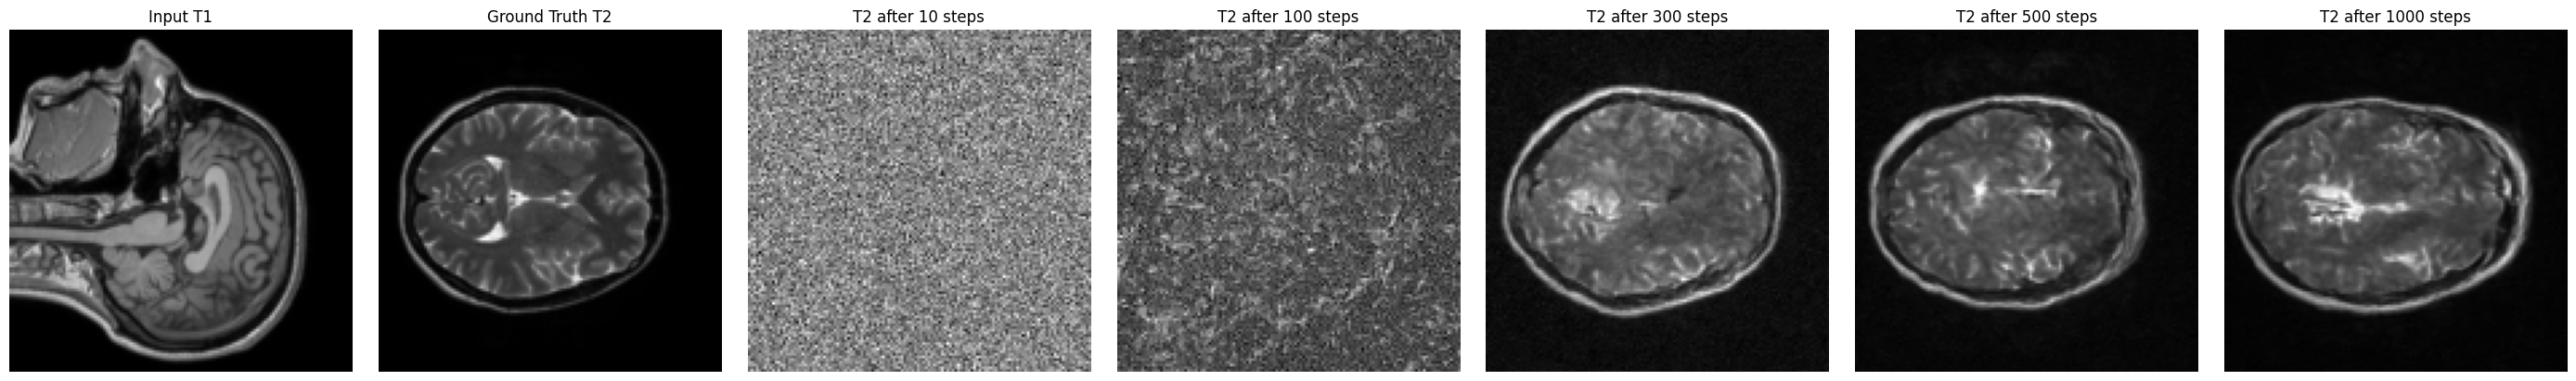

In [48]:
import matplotlib.pyplot as plt

# Visualize samples at different step counts
def visualize_samples(t1_input, t2_real, samples_dict, save_path=None):
    """Visualizes T1→T2 generation at different reverse diffusion steps."""
    # Number of samples to display (up to 3)
    n_samples = min(3, t1_input.shape[0])
    n_steps = len(samples_dict)

    fig, axes = plt.subplots(n_samples, n_steps + 2, figsize=(4 * (n_steps + 2), 4 * n_samples))

    # Handle case where n_samples is 1
    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(n_samples):
        # Input T1
        axes[i, 0].imshow(t1_input[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 0].set_title('Input T1')
        axes[i, 0].axis('off')

        # Ground truth T2
        axes[i, 1].imshow(t2_real[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 1].set_title('Ground Truth T2')
        axes[i, 1].axis('off')

        # Generated T2 at different steps
        col = 2
        for steps, samples in sorted(samples_dict.items()):
            axes[i, col].imshow(samples[i, 0].cpu().numpy(), cmap='gray')
            axes[i, col].set_title(f'T2 after {steps} steps')
            axes[i, col].axis('off')
            col += 1

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)

    plt.show()

# After running all your sampling steps, call the visualization function:
visualize_samples(
    t1_input=t1_images,
    t2_real=t2_images,
    samples_dict=samples_at_steps,
    save_path='t1_to_t2_progression.png'
)